C:\Users\paulo.ramos\AppData\Local\Temp\ipykernel_6472\3280692959.py:97: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idx = pd.date_range("2005-01-01", periods=T, freq="M")



Datos (head):
                 cred        pi       gap         i        fx    copper  \
date                                                                     
2005-01-31  4.759916 -0.056000 -0.655135  0.033246  1.536466 -1.946536   
2005-02-28  4.918902 -0.014410 -0.402446  0.420435  2.061881  0.381553   
2005-03-31  4.833910 -0.086728 -0.451536  0.464868  1.648318 -1.813400   
2005-04-30  4.574887  0.130827 -0.002405  0.477802  0.636375  0.222934   
2005-05-31  5.017773  0.696450 -0.027934  1.033375  0.731558  1.726361   
2005-06-30  5.183105 -0.061539  0.471989  1.392886  0.648265 -2.803747   
2005-07-31  6.318010  0.234973  0.553899  1.574775  1.002362  0.487494   
2005-08-31  7.109782  0.289907  1.036098  2.000949  1.562206  0.540066   
2005-09-30  7.862186  0.417592 -0.835197  2.072491  0.734329 -3.707027   
2005-10-31  8.239440  0.400372 -1.849196  2.170559  1.154852  0.600265   

               dcred  
date                  
2005-01-31  0.000000  
2005-02-28  0.158986  
200

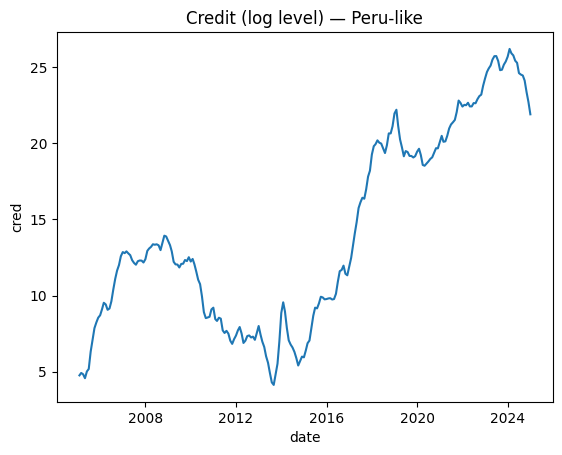

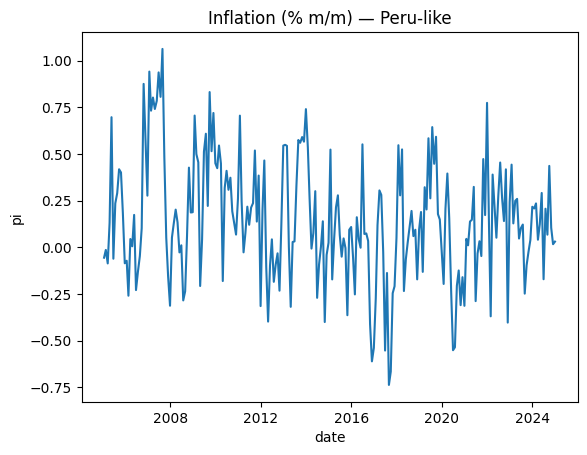

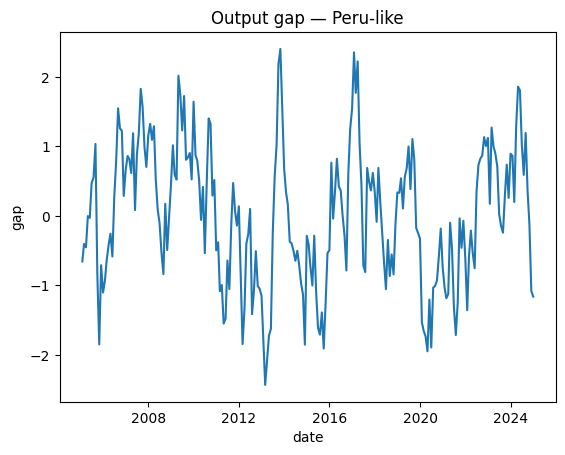

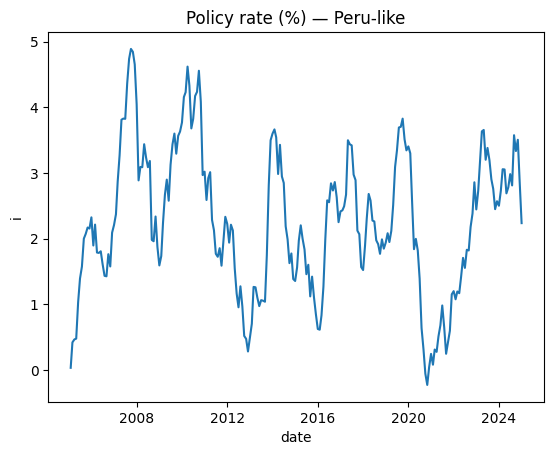

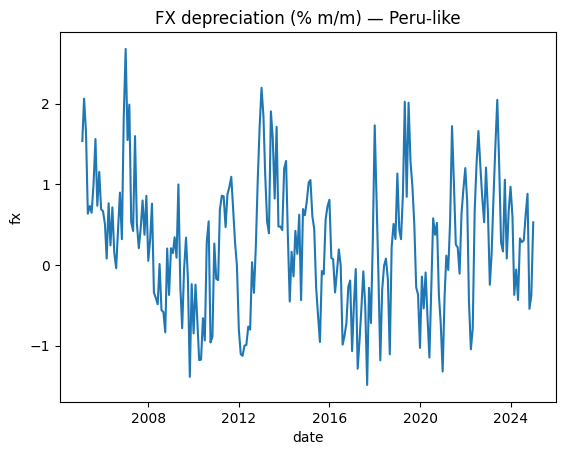

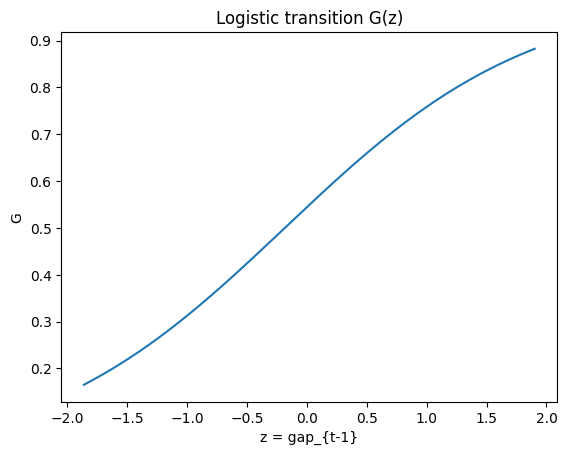

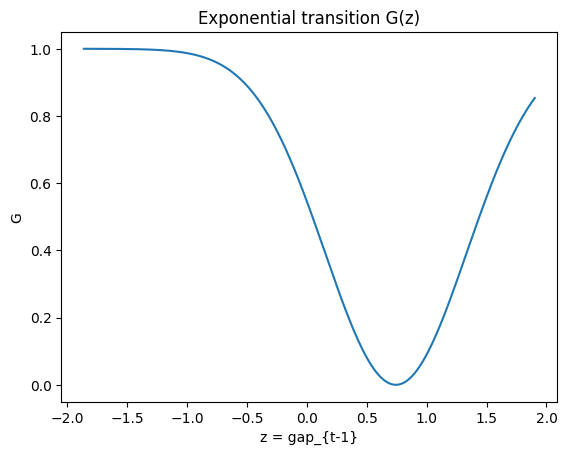

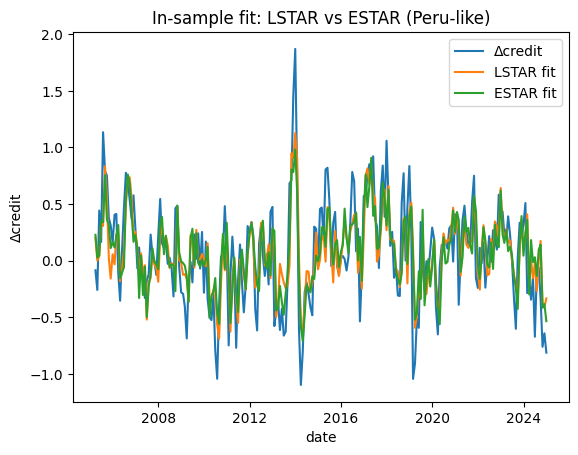

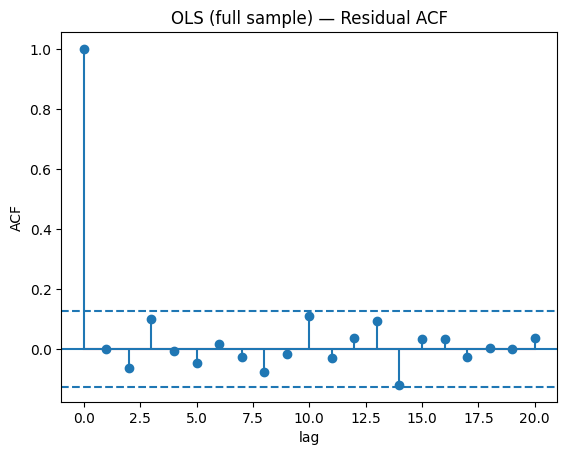

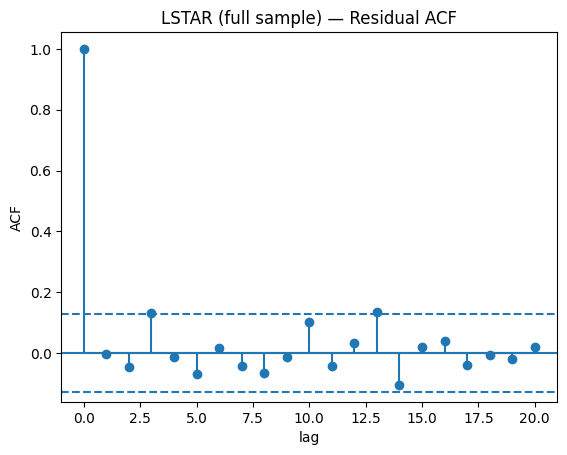

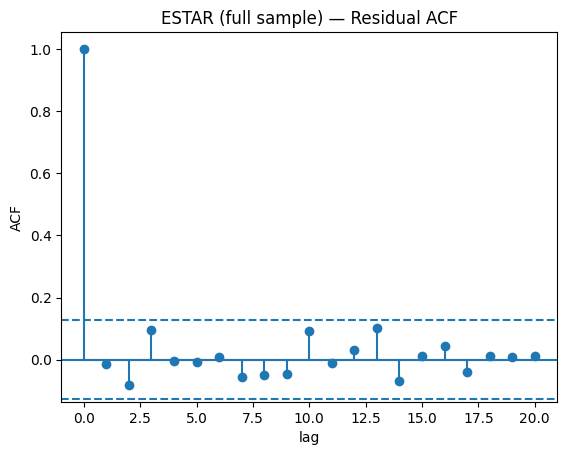

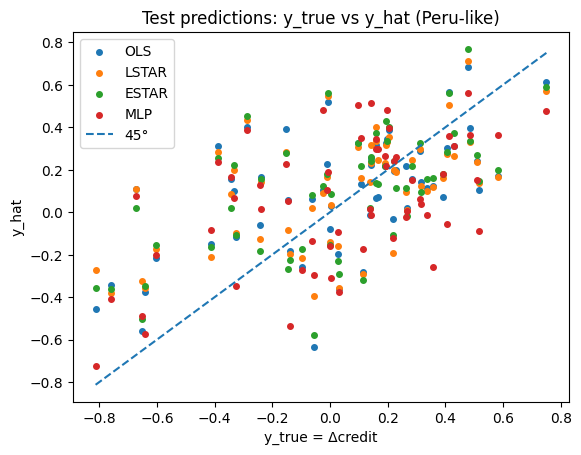

In [4]:
# ===============================================================
#  LSTAR / ESTAR + OLS + MLP sobre datos "Perú-like"
#  -------------------------------------------------
#  1) Simulación de datos (mensual, 2005-2024)
#  2) Construcción de regresores (Δcrédito como dependiente)
#  3) Estimación: OLS, LSTAR (logística), ESTAR (exponencial)
#  4) MLP como comparador (sklearn o fallback NumPy)
#  5) Prueba de linealidad (Teräsvirta-style), métricas OOS y gráficos
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import lstsq, inv, solve, norm

# -----------------------------
# Utilidades
# -----------------------------
def acf(x, nlags=20):
    """Autocorrelación clásica con media removida."""
    x = np.asarray(x) - np.asarray(x).mean()
    den = float(x @ x) if float(x @ x) != 0 else 1.0
    ac = [1.0]
    for k in range(1, nlags+1):
        ac.append(float(x[:-k] @ x[k:]) / den if len(x)>k else 0.0)
    return np.array(ac)

def rmse(y_true, y_pred):
    r = np.asarray(y_true) - np.asarray(y_pred)
    return float(np.sqrt(np.mean(r**2)))

def mae(y_true, y_pred):
    r = np.asarray(y_true) - np.asarray(y_pred)
    return float(np.mean(np.abs(r)))

def train_test_split_time(X, y, test_frac=0.25):
    """Split temporal: último 25% para test (no aleatorio)."""
    n = len(y); n_test = int(round(test_frac * n))
    return (X[:-n_test], y[:-n_test], X[-n_test:], y[-n_test:])

# -----------------------------
# (1) Simulación mensual "Perú-like"
# -----------------------------
def simulate_peru_macro(T=240, seed=517):
    """
    Variables:
      cred: log de cartera de créditos
      dcred: Δlog(cred) mensual
      pi: inflación mensual (% m/m, target ~0.25)
      gap: brecha del producto
      i: tasa de política (%)
      fx: depreciación mensual TC (% m/m)
      copper: retorno del cobre (% m/m)
    Estilizado: regla tipo Taylor, pass-through parcial a pi de fx y ciclo,
    fx reacciona a tasas y cobre, crédito procíclico y no lineal (STAR) en gap.
    """
    rng = np.random.default_rng(seed)
    cred = np.zeros(T+200)   # nivel log
    pi   = np.zeros(T+200)   # % m/m
    gap  = np.zeros(T+200)
    i    = np.zeros(T+200)   # %
    fx   = np.zeros(T+200)   # % m/m
    copper = np.zeros(T+200) # % m/m

    pi_target = 0.25  # ~3% anualizado
    i_star = 4.0      # tasa neutral

    for t in range(1, T+200):
        # Ciclo y commodities
        copper[t] = 0.30*copper[t-1] + rng.normal(0, 2.0)
        gap[t]    = 0.92*gap[t-1] + 0.08*(copper[t-1]/10.0) + rng.normal(0, 0.6)

        # Inflación anclada + ciclo + TC
        pi[t] = (0.65*pi[t-1] + 0.20*(pi_target - pi[t-1])
                 + 0.08*gap[t-1] + 0.06*fx[t-1] + rng.normal(0, 0.25))

        # Tasa de política (regla tipo Taylor)
        i[t] = (0.85*i[t-1] + 0.10*i_star
                + 0.50*(pi[t-1] - pi_target) + 0.15*gap[t-1] + rng.normal(0, 0.25))

        # Depreciación TC: sensible a tasa y cobre
        fx[t] = (0.70*fx[t-1] - 0.04*(i[t-1]-i_star) - 0.05*copper[t-1] + rng.normal(0, 0.6))

        # Crédito: Δcred con LSTAR en el ciclo
        dcred_lag = cred[t-1]-cred[t-2] if t>1 else 0.0
        x = np.array([1.0, dcred_lag, gap[t-1], pi[t-1], i[t-1], fx[t-1], copper[t-1]])
        b = np.array([0.15, 0.35, 0.08, -0.05, -0.06, -0.03, 0.01])   # base (régimen 1)
        d = np.array([0.00, 0.25, 0.12, -0.02, -0.04, -0.02, 0.00])   # incremento en régimen 2
        gamma_true, c_true = 3.5, 0.0

        # Logística robusta (evita overflow)
        tstar = np.clip(gamma_true*(gap[t-1]-c_true), -35.0, 35.0)
        G = 1.0/(1.0 + np.exp(-tstar))
        dcred = b @ x + (d @ x)*G + rng.normal(0, 0.35)
        cred[t] = cred[t-1] + dcred

    idx = pd.date_range("2005-01-01", periods=T, freq="M")
    df = pd.DataFrame({
        "date": idx,
        "cred": cred[-T:], "pi": pi[-T:], "gap": gap[-T:],
        "i": i[-T:], "fx": fx[-T:], "copper": copper[-T:]
    }).set_index("date")
    df["dcred"] = df["cred"].diff().fillna(0.0)
    return df

df = simulate_peru_macro(T=240, seed=517)
print("\nDatos (head):\n", df.head(10))

# -----------------------------
# (2) Construcción de regresores con rezagos
# -----------------------------
def build_regression_df(df, lags=2, dep="dcred", thr_var="gap", dropna=True):
    """
    dependiente: dep
    regresores: const, dcred_l1..L, gap_l1..L, pi_l1..L, i_l1..L, fx_l1..L, copper_l1..L
    z_thr: variable de transición (thr_var) con retardo 1
    """
    out = pd.DataFrame(index=df.index)
    out[dep] = df[dep]
    out["const"] = 1.0
    for L in range(1, lags+1):
        out[f"dcred_l{L}"]  = df["dcred"].shift(L)
        out[f"gap_l{L}"]    = df["gap"].shift(L)
        out[f"pi_l{L}"]     = df["pi"].shift(L)
        out[f"i_l{L}"]      = df["i"].shift(L)
        out[f"fx_l{L}"]     = df["fx"].shift(L)
        out[f"copper_l{L}"] = df["copper"].shift(L)
    out["z_thr"] = df[thr_var].shift(1)
    if dropna:
        out = out.dropna().reset_index()
    return out

regdf = build_regression_df(df, lags=2, dep="dcred", thr_var="gap", dropna=True)
y = regdf["dcred"].to_numpy(float)
X_cols = [c for c in regdf.columns if c not in ["dcred","z_thr","date"]]
X = regdf[X_cols].to_numpy(float)
z = regdf["z_thr"].to_numpy(float)
print("\nColumnas de X:\n", X_cols)

# -----------------------------
# (3) OLS baseline
# -----------------------------
def fit_ols(X, y):
    beta = lstsq(X, y, rcond=None)[0]
    yhat = X @ beta
    resid = y - yhat
    n, k = X.shape
    s2 = (resid @ resid) / max(1, (n - k))
    cov = s2 * inv(X.T @ X)
    return {"beta": beta, "yhat": yhat, "resid": resid, "cov": cov}

ols = fit_ols(X, y)

# -----------------------------
# (4) STAR (LSTAR / ESTAR) — funciones de transición + estimación robusta
# -----------------------------
def logistic_G(z, gamma, c):
    t = np.clip(gamma*(z - c), -35.0, 35.0)
    return 1.0/(1.0 + np.exp(-t))

def logistic_partials(z, gamma, c):
    t = np.clip(gamma*(z - c), -35.0, 35.0)
    G = 1.0/(1.0 + np.exp(-t))
    g_gamma = (z - c) * G * (1.0 - G)   # dG/dγ
    g_c     = -gamma * G * (1.0 - G)    # dG/dc
    return G, g_gamma, g_c

def exponential_G(z, gamma, c):
    u = -gamma*(z - c)**2
    u = np.clip(u, -60.0, 0.0)
    return 1.0 - np.exp(u)

def exponential_partials(z, gamma, c):
    u = -gamma*(z - c)**2
    u = np.clip(u, -60.0, 0.0)
    expo = np.exp(u)
    G = 1.0 - expo
    g_gamma = (z - c)**2 * expo
    g_c     = -2.0 * gamma * (z - c) * expo
    return G, g_gamma, g_c

def star_fit_robust(X, y, z, kind="logistic", max_iter=800, tol=1e-7, lam0=5e-2):
    """
    y = X b + (X d) G(z;γ,c) + e  (STAR)
    Estimador LM robusto:
      - clipping en G
      - ajuste dinámico de lambda
      - saneamiento de Jacobiano si aparece no finito
    Retorna: theta, b, d, gamma, c, G, yhat, resid, cov_white, history
    """
    n, K = X.shape
    med = float(np.nanmedian(z))
    I1 = z <= med; I2 = ~I1
    b0 = lstsq(X[I1], y[I1], rcond=None)[0]
    b2 = lstsq(X[I2], y[I2], rcond=None)[0]
    d0 = b2 - b0
    gamma0, c0 = 1.0, med
    theta = np.concatenate([b0, d0, np.array([gamma0, c0])])
    lam = lam0
    hist = []

    for it in range(max_iter):
        b = theta[:K]; d = theta[K:2*K]; gamma, c = float(theta[-2]), float(theta[-1])
        if kind=="logistic":
            G, g_gam, g_c = logistic_partials(z, gamma, c)
        else:
            gamma = max(gamma, 1e-6); theta[-2] = gamma
            G, g_gam, g_c = exponential_partials(z, gamma, c)

        Xd = X @ d
        yhat = X @ b + Xd * G
        r = y - yhat
        if not np.all(np.isfinite(r)):
            lam *= 10.0
            continue

        # Jacobiano
        J = np.zeros((n, 2*K + 2))
        J[:, :K]      = X
        J[:, K:2*K]   = (X.T * G).T
        J[:, -2]      = -Xd * g_gam
        J[:, -1]      = -Xd * g_c
        J = np.where(np.isfinite(J), J, 0.0)

        A = J.T @ J + lam * np.eye(J.shape[1])
        gvec = J.T @ r
        try:
            delta = solve(A, gvec)
        except Exception:
            delta = lstsq(A, gvec, rcond=None)[0]

        if not np.all(np.isfinite(delta)):
            lam *= 10.0
            continue

        theta_new = theta + delta
        bN = theta_new[:K]; dN = theta_new[K:2*K]; gammaN, cN = float(theta_new[-2]), float(theta_new[-1])
        if kind=="logistic":
            GN = logistic_G(z, gammaN, cN)
        else:
            gammaN = max(gammaN, 1e-6); theta_new[-2] = gammaN
            GN = exponential_G(z, gammaN, cN)
        yhat_new = X @ bN + (X @ dN) * GN

        rss_old = float(r @ r); rss_new = float(np.sum((y - yhat_new)**2))
        hist.append({"iter": it, "RSS": rss_old, "lam": lam, "step_norm": float(norm(delta))})

        if (rss_new < rss_old) and np.isfinite(rss_new):
            theta = theta_new
            lam = max(lam/3, 1e-9)
            if norm(delta) < tol:
                break
        else:
            lam *= 7.0

    # Final
    b = theta[:K]; d = theta[K:2*K]; gamma, c = float(theta[-2]), float(theta[-1])
    if kind=="logistic":
        G, g_gam, g_c = logistic_partials(z, gamma, c)
    else:
        G, g_gam, g_c = exponential_partials(z, gamma, c)
    yhat = X @ b + (X @ d) * G
    resid = y - yhat

    # White SE
    Xd = X @ d
    J = np.zeros((n, 2*K + 2))
    J[:, :K]      = X
    J[:, K:2*K]   = (X.T * G).T
    J[:, -2]      = -Xd * g_gam
    J[:, -1]      = -Xd * g_c
    J = np.where(np.isfinite(J), J, 0.0)

    JTJ = J.T @ J
    try:
        JTJ_inv = inv(JTJ)
    except Exception:
        JTJ_inv = np.linalg.pinv(JTJ)
    meat = J.T @ (J * (resid[:, None]**2))
    cov_white = JTJ_inv @ meat @ JTJ_inv

    return {"theta": theta, "b": b, "d": d, "gamma": gamma, "c": c, "G": G,
            "yhat": yhat, "resid": resid, "cov_white": cov_white,
            "history": pd.DataFrame(hist)}

# Estimación full-sample para visualizar
lstar_full = star_fit_robust(X, y, z, kind="logistic")
estar_full = star_fit_robust(X, y, z, kind="exponential")

def white_se(fit):
    return np.sqrt(np.diag(fit["cov_white"])) if fit["cov_white"] is not None else np.nan

def table_star_params(fit, X_cols, name):
    K = len(X_cols)
    theta = fit["theta"]
    se = white_se(fit)
    names = [f"b:{c}" for c in X_cols] + [f"d:{c}" for c in X_cols] + ["gamma","c"]
    tab = pd.DataFrame({"param":names, "estimate":theta, "SE_White":se})
    print("\n", name, "\n", tab.round(4).to_string(index=False))

table_star_params(lstar_full, X_cols, "LSTAR (full-sample) — parámetros (White SE)")
table_star_params(estar_full, X_cols, "ESTAR (full-sample) — parámetros (White SE)")

# -----------------------------
# (5) Prueba de linealidad (Teräsvirta-style LM)
# -----------------------------
def terasvirta_LM_test(X, y, z):
    """
    1) e = y - X beta (OLS)
    2) Regress e sobre [X·z, X·z^2, X·z^3] parcializados respecto a X.
    3) LM ≈ n * R^2 (df ≈ 3K).
    """
    beta = lstsq(X, y, rcond=None)[0]
    e = y - X @ beta
    Z = np.hstack([(X.T * (z**m)).T for m in (1,2,3)])
    n, K = X.shape
    XtX_inv = inv(X.T @ X)
    Mx = np.eye(n) - X @ XtX_inv @ X.T  # residual-maker respecto a X
    e_tilde = Mx @ e
    Z_tilde = Mx @ Z
    beta_aux = lstsq(Z_tilde, e_tilde, rcond=None)[0]
    resid_aux = e_tilde - Z_tilde @ beta_aux
    R2 = 1.0 - float(resid_aux @ resid_aux) / float(e_tilde @ e_tilde)
    LM = n * R2
    df = Z.shape[1]
    return {"LM": LM, "df": df, "R2_partial": R2}

lm = terasvirta_LM_test(X, y, z)
print("\nLinearity check (Teräsvirta-style):\n", pd.DataFrame([lm]).round(4))

# -----------------------------
# (6) Red neuronal (MLP) — sklearn o fallback NumPy
# -----------------------------
def fit_mlp(X, y, test_frac=0.25, random_state=7):
    """
    Entrena MLP con dos capas tanh.
      - Si hay scikit-learn: StandardScaler + MLPRegressor(32,16)
      - Si no: fallback NumPy (32→16→1), 6000 iter, lr=1e-3
    Retorna dict con yhat_tr, yhat_te, ytr, yte.
    """
    try:
        from sklearn.preprocessing import StandardScaler
        from sklearn.neural_network import MLPRegressor
        n = len(y); n_test = int(round(test_frac * n))
        Xtr, ytr = X[:-n_test], y[:-n_test]; Xte, yte = X[-n_test:], y[-n_test:]
        ss = StandardScaler(); Xtr_s = ss.fit_transform(Xtr); Xte_s = ss.transform(Xte)
        mlp = MLPRegressor(hidden_layer_sizes=(32,16), activation="tanh",
                           alpha=1e-4, solver="adam", learning_rate_init=1e-3,
                           max_iter=4000, random_state=random_state)
        mlp.fit(Xtr_s, ytr)
        yhat_tr = mlp.predict(Xtr_s); yhat_te = mlp.predict(Xte_s)
        return {"backend":"sklearn", "yhat_tr":yhat_tr, "yhat_te":yhat_te, "ytr":ytr, "yte":yte}
    except Exception:
        # Fallback NumPy
        n = len(y); n_test = int(round(test_frac * n))
        Xtr, ytr = X[:-n_test], y[:-n_test]; Xte, yte = X[-n_test:], y[-n_test:]
        mu = Xtr.mean(axis=0); sd = Xtr.std(axis=0) + 1e-8
        Xtr_s = (Xtr - mu)/sd; Xte_s = (Xte - mu)/sd
        rng = np.random.default_rng(random_state)
        D, H1, H2 = X.shape[1], 32, 16
        W1 = rng.normal(0, 0.1, size=(D, H1)); b1 = np.zeros(H1)
        W2 = rng.normal(0, 0.1, size=(H1, H2)); b2 = np.zeros(H2)
        W3 = rng.normal(0, 0.1, size=(H2, 1));  b3 = np.zeros(1)
        lr = 1e-3
        for it in range(6000):
            h1 = np.tanh(Xtr_s @ W1 + b1)
            h2 = np.tanh(h1 @ W2 + b2)
            yhat = (h2 @ W3 + b3).ravel()
            r = ytr - yhat
            dW3 = -(h2.T @ r[:,None]) / len(ytr); db3 = -r.mean()
            dh2 = r[:,None] @ W3.T; dact2 = (1 - h2**2)*dh2
            dW2 = -(h1.T @ dact2) / len(ytr); db2 = -dact2.mean(axis=0)
            dh1 = dact2 @ W2.T; dact1 = (1 - h1**2)*dh1
            dW1 = -(Xtr_s.T @ dact1) / len(ytr); db1 = -dact1.mean(axis=0)
            W3 -= lr*dW3; b3 -= lr*db3; W2 -= lr*dW2; b2 -= lr*db2; W1 -= lr*dW1; b1 -= lr*db1
        yhat_tr = (np.tanh(np.tanh(Xtr_s @ W1 + b1) @ W2 + b2) @ W3 + b3).ravel()
        yhat_te = (np.tanh(np.tanh(Xte_s @ W1 + b1) @ W2 + b2) @ W3 + b3).ravel()
        return {"backend":"numpy", "yhat_tr":yhat_tr, "yhat_te":yhat_te, "ytr":ytr, "yte":yte}

# -----------------------------
# (7) Entrenamiento/evaluación OOS
# -----------------------------
Xtr, ytr, Xte, yte = train_test_split_time(X, y, test_frac=0.25)
ztr, zte = train_test_split_time(z, y, test_frac=0.25)[0::2]

# OLS
ols_tr = lstsq(Xtr, ytr, rcond=None)[0]
yhat_ols_te = Xte @ ols_tr

# STAR (robustos) en training, predicción en test
lstar_tr = star_fit_robust(Xtr, ytr, ztr, kind="logistic")
estar_tr = star_fit_robust(Xtr, ytr, ztr, kind="exponential")

def star_predict(fit, Xnew, znew, kind="logistic"):
    b, d, gamma, c = fit["b"], fit["d"], fit["gamma"], fit["c"]
    G = logistic_G(znew, gamma, c) if kind=="logistic" else exponential_G(znew, gamma, c)
    return Xnew @ b + (Xnew @ d) * G

yhat_lstar_te = star_predict(lstar_tr, Xte, zte, kind="logistic")
yhat_estar_te = star_predict(estar_tr, Xte, zte, kind="exponential")

# MLP
mlp = fit_mlp(X, y, test_frac=0.25, random_state=7)

perf = pd.DataFrame({
    "Model":["OLS","LSTAR","ESTAR","MLP("+mlp["backend"]+")"],
    "RMSE_test":[rmse(yte, yhat_ols_te), rmse(yte, yhat_lstar_te), rmse(yte, yhat_estar_te), rmse(mlp["yte"], mlp["yhat_te"])],
    "MAE_test":[mae(yte, yhat_ols_te), mae(yte, yhat_lstar_te), mae(yte, yhat_estar_te), mae(mlp["yte"], mlp["yhat_te"])]
})
print("\nPerformance OOS (Δcredit):\n", perf.round(4).to_string(index=False))

# -----------------------------
# (8) Gráficos (una figura por plot, sin estilos ni colores específicos)
# -----------------------------
# Series principales
plt.figure(); plt.plot(df.index, df["cred"]); plt.title("Credit (log level) — Peru-like"); plt.xlabel("date"); plt.ylabel("cred"); plt.show()
plt.figure(); plt.plot(df.index, df["pi"]);   plt.title("Inflation (% m/m) — Peru-like"); plt.xlabel("date"); plt.ylabel("pi"); plt.show()
plt.figure(); plt.plot(df.index, df["gap"]);  plt.title("Output gap — Peru-like"); plt.xlabel("date"); plt.ylabel("gap"); plt.show()
plt.figure(); plt.plot(df.index, df["i"]);    plt.title("Policy rate (%) — Peru-like"); plt.xlabel("date"); plt.ylabel("i"); plt.show()
plt.figure(); plt.plot(df.index, df["fx"]);   plt.title("FX depreciation (% m/m) — Peru-like"); plt.xlabel("date"); plt.ylabel("fx"); plt.show()

# Transiciones (full sample)
zz = np.linspace(np.percentile(z, 2), np.percentile(z, 98), 200)
G_log = logistic_G(zz, lstar_full["gamma"], lstar_full["c"])
G_exp = exponential_G(zz, estar_full["gamma"], estar_full["c"])
plt.figure(); plt.plot(zz, G_log); plt.title("Logistic transition G(z)"); plt.xlabel("z = gap_{t-1}"); plt.ylabel("G"); plt.show()
plt.figure(); plt.plot(zz, G_exp); plt.title("Exponential transition G(z)"); plt.xlabel("z = gap_{t-1}"); plt.ylabel("G"); plt.show()

# Ajuste in-sample (full sample) LSTAR/ESTAR
plt.figure()
plt.plot(regdf["date"], y, label="Δcredit")
plt.plot(regdf["date"], lstar_full["yhat"], label="LSTAR fit")
plt.plot(regdf["date"], estar_full["yhat"], label="ESTAR fit")
plt.title("In-sample fit: LSTAR vs ESTAR (Peru-like)")
plt.xlabel("date"); plt.ylabel("Δcredit"); plt.legend(); plt.show()

# ACF de residuales (full sample)
def plot_resid_acf(resid, title, nlags=20):
    ac = acf(resid, nlags=nlags); x = np.arange(len(ac))
    plt.figure()
    try:
        plt.stem(x, ac, use_line_collection=True)
    except TypeError:
        plt.stem(x, ac)
    plt.axhline(0)
    band = 1.96/np.sqrt(len(resid)) if len(resid)>0 else 0.0
    plt.axhline(band, linestyle="--"); plt.axhline(-band, linestyle="--")
    plt.title(title + " — Residual ACF"); plt.xlabel("lag"); plt.ylabel("ACF"); plt.show()

plot_resid_acf(ols["resid"], "OLS (full sample)")
plot_resid_acf(lstar_full["resid"], "LSTAR (full sample)")
plot_resid_acf(estar_full["resid"], "ESTAR (full sample)")

# Dispersión: predicciones en test
plt.figure()
plt.scatter(yte, yhat_ols_te, s=16, label="OLS")
plt.scatter(yte, yhat_lstar_te, s=16, label="LSTAR")
plt.scatter(yte, yhat_estar_te, s=16, label="ESTAR")
plt.scatter(mlp["yte"], mlp["yhat_te"], s=16, label="MLP")
mn = float(min(yte.min(), mlp["yte"].min())); mx = float(max(yte.max(), mlp["yte"].max()))
plt.plot([mn, mx], [mn, mx], linestyle="--", label="45°")
plt.title("Test predictions: y_true vs y_hat (Peru-like)")
plt.xlabel("y_true = Δcredit"); plt.ylabel("y_hat"); plt.legend(); plt.show()
